In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# 国勢調査-収入データセットをダウンロードする

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# データをロードして分割する

In [4]:
train = pd.read_csv(out)
target = 'income'
if 'Set' not in train.columns:
    train['Set'] = np.random.choice(['train', 'valid', 'test'], p=[.8, .1, .1], size=(train.shape[0],))
train_indices = train[train.Set=='train'].index
valid_indices = train[train.Set=='valid'].index
test_indices = train[train.Set=='test'].index

In [5]:
train[train.Set=='train']

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,Set
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K,train
32555,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,train
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,train


In [6]:
train[train.Set=='valid']

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,Set
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,valid
17,32,Private,186824,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,United-States,<=50K,valid
19,43,Self-emp-not-inc,292175,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,>50K,valid
66,28,Private,183175,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K,valid
68,49,Self-emp-inc,191681,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K,valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32536,34,Private,160216,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States,>50K,valid
32540,45,State-gov,252208,HS-grad,9,Separated,Adm-clerical,Own-child,White,Female,0,0,40,United-States,<=50K,valid
32542,72,?,129912,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,25,United-States,<=50K,valid
32548,65,Self-emp-not-inc,99359,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,1086,0,60,United-States,<=50K,valid


In [7]:
train[train.Set=='test']

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,Set
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,test
13,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,<=50K,test
20,40,Private,193524,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K,test
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K,test
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,>50K,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32516,30,Private,176175,Assoc-voc,11,Divorced,Adm-clerical,Unmarried,White,Female,0,0,24,United-States,<=50K,test
32537,30,Private,345898,HS-grad,9,Never-married,Craft-repair,Not-in-family,Black,Male,0,0,46,United-States,<=50K,test
32546,37,Private,198216,Assoc-acdm,12,Divorced,Tech-support,Not-in-family,White,Female,0,0,40,United-States,<=50K,test
32552,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K,test


In [8]:
train_indices

Int64Index([    0,     1,     2,     3,     4,     5,     6,     9,    10,
               11,
            ...
            32547, 32549, 32550, 32551, 32553, 32554, 32555, 32557, 32558,
            32559],
           dtype='int64', length=26072)

In [9]:
valid_indices

Int64Index([    7,    17,    19,    66,    68,    98,   111,   114,   116,
              118,
            ...
            32494, 32520, 32523, 32533, 32535, 32536, 32540, 32542, 32548,
            32556],
           dtype='int64', length=3221)

In [10]:
test_indices

Int64Index([    8,    13,    20,    27,    38,    52,    70,    72,    89,
              103,
            ...
            32424, 32434, 32485, 32497, 32513, 32516, 32537, 32546, 32552,
            32560],
           dtype='int64', length=3268)

# 簡単な前処理
ラベルはカテゴリの特徴をエンコードし、空のセルを埋めます。

In [11]:
nunique = train.nunique()
types = train.dtypes

display(nunique)
display(types)

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
Set                   3
dtype: int64

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
Set               object
dtype: object

In [12]:
categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna('VV_likely')
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

age 73
workclass 9
education 16
education.num 16
marital.status 7
occupation 15
relationship 6
race 5
sex 2
capital.gain 119
capital.loss 92
hours.per.week 94
native.country 42
income 2
Set 3


In [13]:
# パイプラインが文字列を受け入れることを確認します
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

In [14]:
train

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,Set
0,22,7,77516,9,12,4,1,1,4,1,25,0,39,39,wealthy,1
1,33,6,83311,9,12,2,4,0,4,1,0,0,12,39,wealthy,1
2,21,4,215646,11,8,0,6,1,4,1,0,0,39,39,wealthy,1
3,36,4,234721,1,6,2,6,0,2,1,0,0,39,39,wealthy,1
4,11,4,338409,9,12,2,10,5,2,0,0,0,39,5,wealthy,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,10,4,257302,7,11,2,13,5,4,0,0,0,37,39,wealthy,2
32557,23,4,154374,11,8,2,7,0,4,1,0,0,39,39,not_wealthy,1
32558,41,4,151910,11,8,6,1,4,4,0,0,0,39,39,wealthy,1
32559,5,4,201490,11,8,4,1,3,4,1,0,0,19,39,wealthy,1


# カテゴリ埋め込みのカテゴリ機能を定義する

In [16]:
unused_feat = ['Set']
features = [col for col in train.columns if col not in unused_feat + [target]]
features

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education.num',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'native.country']

In [17]:
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_idxs

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [19]:
cat_dims = [categorical_dims[f] for f in features if f in categorical_columns]
cat_dims

[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]

# ネットワークパラメータ

In [39]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={'step_size': 50, # 学習率スケジューラの使用方法
                                         'gamma': 0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


# トレーニング

In [21]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

print(X_train)
print(y_train)

[[    22      7  77516 ...      0     39     39]
 [    33      6  83311 ...      0     12     39]
 [    21      4 215646 ...      0     39     39]
 ...
 [    23      4 154374 ...      0     39     39]
 [    41      4 151910 ...      0     39     39]
 [     5      4 201490 ...      0     19     39]]
['wealthy' 'wealthy' 'wealthy' ... 'not_wealthy' 'wealthy' 'wealthy']


In [21]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

print(X_train)
print(y_train)

[[    22      7  77516 ...      0     39     39]
 [    33      6  83311 ...      0     12     39]
 [    21      4 215646 ...      0     39     39]
 ...
 [    23      4 154374 ...      0     39     39]
 [    41      4 151910 ...      0     39     39]
 [     5      4 201490 ...      0     19     39]]
['wealthy' 'wealthy' 'wealthy' ... 'not_wealthy' 'wealthy' 'wealthy']


In [22]:
X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [23]:
max_epochs = 1000 if not os.getenv('CI', False) else 2
max_epochs

1000

In [29]:
# 環境変数 key が存在すればその値を返し、存在しなければ default を返します。
# key、default、および返り値は文字列です。
os.getenv('CI', False)

False

In [41]:
clf.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    # max_epochs=max_epochs,
    max_epochs=100,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=1, 
    drop_last=False
)

epoch 0  | loss: 0.32346 | train_auc: 0.9357  | valid_auc: 0.92524 |  0:00:04s
epoch 1  | loss: 0.32366 | train_auc: 0.9366  | valid_auc: 0.92663 |  0:00:08s
epoch 2  | loss: 0.32367 | train_auc: 0.93777 | valid_auc: 0.92516 |  0:00:12s
epoch 3  | loss: 0.31477 | train_auc: 0.93845 | valid_auc: 0.92717 |  0:00:19s
epoch 4  | loss: 0.3143  | train_auc: 0.93717 | valid_auc: 0.92429 |  0:00:24s
epoch 5  | loss: 0.31321 | train_auc: 0.93776 | valid_auc: 0.92301 |  0:00:30s
epoch 6  | loss: 0.31772 | train_auc: 0.93918 | valid_auc: 0.92573 |  0:00:37s
epoch 7  | loss: 0.31279 | train_auc: 0.93955 | valid_auc: 0.92356 |  0:00:47s
epoch 8  | loss: 0.31531 | train_auc: 0.9388  | valid_auc: 0.92329 |  0:00:53s
epoch 9  | loss: 0.31646 | train_auc: 0.93822 | valid_auc: 0.92292 |  0:00:58s
epoch 10 | loss: 0.31419 | train_auc: 0.93926 | valid_auc: 0.92385 |  0:01:03s
epoch 11 | loss: 0.30801 | train_auc: 0.94004 | valid_auc: 0.92701 |  0:01:08s
epoch 12 | loss: 0.31327 | train_auc: 0.94028 | vali

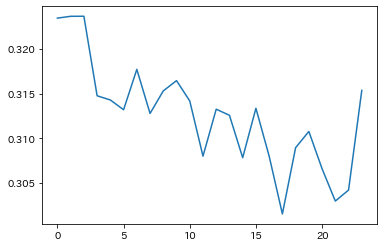

In [42]:
# plot losses
plt.plot(clf.history['loss'])

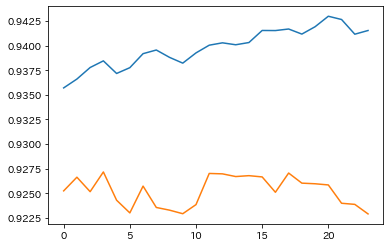

In [43]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

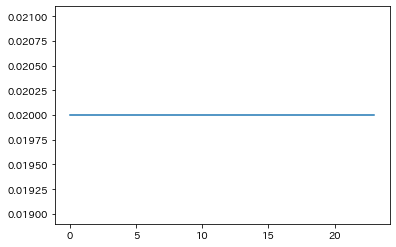

In [44]:
# plot learning rates
plt.plot(clf.history['lr'])

# 予測

In [45]:
preds = clf.predict_proba(X_test)
preds

array([[9.9995494e-01, 4.5080997e-05],
       [5.5625178e-02, 9.4437486e-01],
       [9.5681196e-01, 4.3188002e-02],
       ...,
       [3.4673387e-01, 6.5326619e-01],
       [7.8716177e-01, 2.1283823e-01],
       [9.9959451e-01, 4.0547986e-04]], dtype=float32)

In [46]:
test_auc = roc_auc_score(y_score=preds[:, 1], y_true=y_test)
test_auc

0.9232819112456718

In [47]:
preds_valid = clf.predict_proba(X_valid)
preds_valid

array([[0.77239156, 0.22760841],
       [0.01244381, 0.98755616],
       [0.47458228, 0.5254178 ],
       ...,
       [0.0519749 , 0.9480251 ],
       [0.0387973 , 0.9612027 ],
       [0.7565427 , 0.24345735]], dtype=float32)

In [48]:
valid_auc = roc_auc_score(y_score=preds_valid[:, 1], y_true=y_valid)
valid_auc

0.9271664073009258

In [49]:
print(f'BEST VALID SCORE FOR {dataset_name}:{clf.best_cost}')
print(f'FINAL TEST SCORE FOR {dataset_name}:{test_auc}')

BEST VALID SCORE FOR census-income:0.9271664073009257
FINAL TEST SCORE FOR census-income:0.9232819112456718


In [50]:
# 最適な重みが使用されていることを確認します
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [54]:
np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

True

In [55]:
print(valid_auc)
print(clf.history['valid_auc'])
print(np.max(clf.history['valid_auc']))

0.9271664073009258
[0.9252446390420173, 0.9266322897159285, 0.925162872893203, 0.9271664073009257, 0.9242945691451481, 0.9230074117057474, 0.9257283781288741, 0.9235586738058186, 0.9232864716587976, 0.9229240629863107, 0.9238493392767653, 0.9270136892358822, 0.9269728061614749, 0.9266987576820616, 0.9267887004457575, 0.9266613035106692, 0.9251032627330994, 0.9270548360720596, 0.9260290665470948, 0.9259662912457468, 0.9258468071637698, 0.9239859678738164, 0.9238733415978687, 0.9229037533299924]
0.9271664073009257


In [51]:
clf.predict(X_test)

array(['not_wealthy', 'wealthy', 'not_wealthy', ..., 'wealthy',
       'not_wealthy', 'not_wealthy'], dtype='<U11')

# モデルの保存と読み込み

In [56]:
# tabnet modelの保存
saving_path_name = './tabnet_model_test_1'
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [57]:
# 基本的なパラメータと負荷状態の指示の重みを使用して新しいモデルを定義します
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [58]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:, 1], y_true=y_test)
print(f'FINAL TEST SCORE FOR {dataset_name}:{loaded_test_auc}')

FINAL TEST SCORE FOR census-income:0.9232819112456718


In [59]:
assert test_auc == loaded_test_auc

In [60]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'wealthy', 'not_wealthy', ..., 'wealthy',
       'not_wealthy', 'not_wealthy'], dtype='<U11')

# グローバルな説明可能性：1に合計する重要性の偉業

In [61]:
clf.feature_importances_

array([0.05734283, 0.02481389, 0.02702152, 0.04393496, 0.10958315,
       0.1865698 , 0.07941923, 0.04487641, 0.02160457, 0.08037257,
       0.2197309 , 0.02771774, 0.05751164, 0.01950077])

# 地域の説明性とマスク

In [62]:
explain_matrix, masks = clf.explain(X_test)

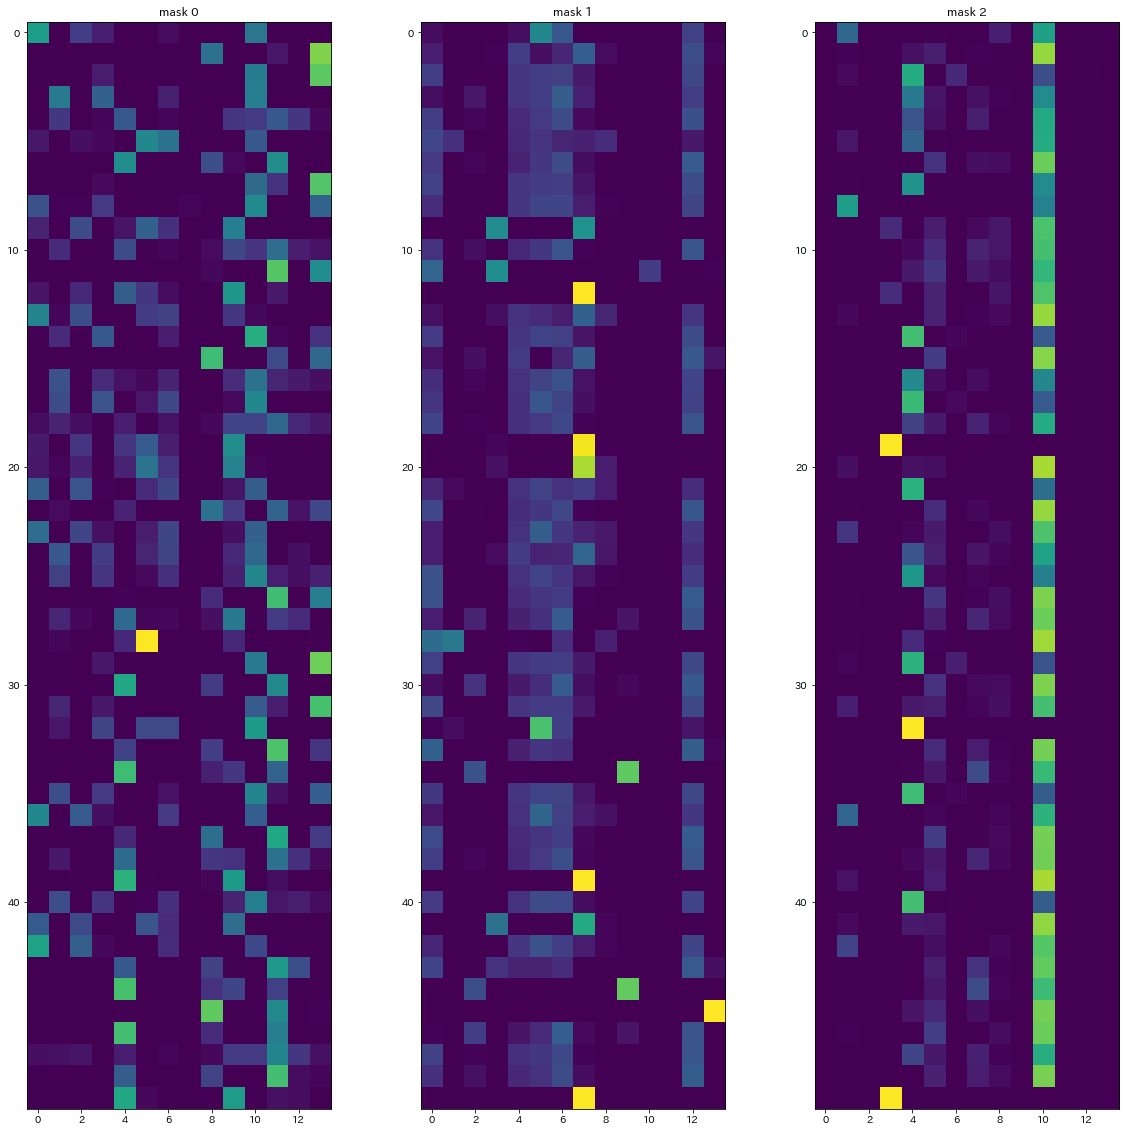

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")